# Initial

In [ ]:
!sudo apt update

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
65 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InR

In [ ]:
!sudo apt install -y libopencv-dev pkg-config

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopencv-dev is already the newest version (4.5.4+dfsg-9ubuntu4+jammy0).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'sudo apt autoremove' to remove them.
The following packages will be REMOVED:
  pkgconf r-base-dev
The following NEW packages will be installed:
  pkg-config
0 upgraded, 1 newly installed, 2 to remove and 65 not upgraded.
Need to get 48.2 kB of archives.
After this operation, 11.3 kB disk space will be freed.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 pkg-config amd64 0.29.2-1ubuntu3 [48.2 kB]
Fetched 48.2 kB in 0s (745 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
deb

In [ ]:
!pkg-config --modversion opencv4

4.5.4


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


# Serial

In [130]:
%%writefile  cpp_serial_version.cpp

#include <opencv2/opencv.hpp>
#include <iostream>
#include <vector>
#include <chrono>

using namespace cv;
using namespace std;

Mat apply_serial_filter(const Mat& img, const vector<vector<int>>& kernel_x, const vector<vector<int>>& kernel_y, double thresh_high, double thresh_low) {
    int rows = img.rows, cols = img.cols;
    Mat grad_x(img.size(), CV_32F, Scalar(0)), grad_y(img.size(), CV_32F, Scalar(0));

    for (int i = 1; i < rows - 1; ++i) {
        for (int j = 1; j < cols - 1; ++j) {
            float sum_x = 0.0f, sum_y = 0.0f;
            for (int ki = -1; ki <= 1; ++ki) {
                for (int kj = -1; kj <= 1; ++kj) {
                    int pixel = static_cast<int>(img.at<uchar>(i + ki, j + kj));
                    sum_x += pixel * kernel_x[ki + 1][kj + 1];
                    sum_y += pixel * kernel_y[ki + 1][kj + 1];
                }
            }
            grad_x.at<float>(i, j) = sum_x;
            grad_y.at<float>(i, j) = sum_y;
        }
    }
    Mat magnitude_img, mag_norm, edges = Mat::zeros(rows, cols, CV_8U);
    magnitude(grad_x, grad_y, magnitude_img);
    double max_val;
    minMaxLoc(magnitude_img, 0, &max_val);
    magnitude_img.convertTo(mag_norm, CV_32F, 255.0 / max_val);

    for (int i = 0; i < rows; ++i) {
        for (int j = 0; j < cols; ++j) {
            float val = mag_norm.at<float>(i, j);
            if (val > thresh_high) edges.at<uchar>(i, j) = 255;
            else if (val > thresh_low) edges.at<uchar>(i, j) = static_cast<uchar>((val - thresh_low) / (thresh_high - thresh_low) * 255);
        }
    }
    return edges;
}

int main() {
    string input_path = "/content/drive/MyDrive/ParallelProgramming/CA/input.jpg";
    string output_path = "/content/drive/MyDrive/ParallelProgramming/CA/output/output_cpp_serial_image.jpg";
    Mat input_image = imread(input_path, IMREAD_GRAYSCALE);
    vector<vector<int>> sobel_x = {
        {-1, 0, 1},
        {-2, 0, 2},
        {-1, 0, 1}
    };
    vector<vector<int>> sobel_y = {
        {1, 2, 1},
        {0, 0, 0},
        {-1, -2, -1}
    };
    double high_threshold = 90.0, low_threshold = 10.0;
    auto start = chrono::high_resolution_clock::now();
    Mat result = apply_serial_filter(input_image, sobel_x, sobel_y, high_threshold, low_threshold);
    auto end = chrono::high_resolution_clock::now();
    chrono::duration<double> elapsed = end - start;
    cout << "Serial Execution Time: " << elapsed.count() << " seconds" << endl;
    bool success = imwrite(output_path, result);
    if (!success) {
        cerr << "Failed to save the image to: " << output_path << endl;
        return -1;
    }
    return 0;
}


Overwriting cpp_serial_version.cpp


In [131]:
!g++ cpp_serial_version.cpp -o cpp `pkg-config --cflags --libs opencv4`

In [132]:
!./cpp

Serial Execution Time: 0.0592757 seconds


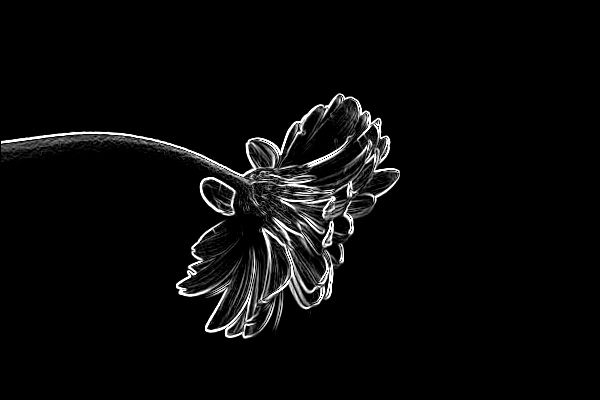

In [133]:
from PIL import Image
output_image = Image.open("/content/drive/MyDrive/ParallelProgramming/CA/output/output_cpp_serial_image.jpg")
display(output_image)

# No-divergence

In [13]:
%%writefile  common.h

#ifndef _COMMON_H
#define _COMMON_H

#include <sys/time.h>
#include <cstdio>
#include <cuda_runtime.h>

#define CHECK(call)                                                                  \
{                                                                                    \
    const cudaError_t error = call;                                                  \
    if (error != cudaSuccess) {                                                      \
        fprintf(stderr, "Error: %s:%d, ", __FILE__, __LINE__);                       \
        fprintf(stderr, "code: %d, reason: %s\n", error, cudaGetErrorString(error)); \
        exit(1);                                                                     \
    }                                                                                \
}

inline double seconds() {
    struct timeval tp;
    struct timezone tzp;
    int i = gettimeofday(&tp, &tzp);
    return ((double)tp.tv_sec + (double)tp.tv_usec * 1.e-6);
}

#endif // _COMMON_H


Writing common.h


In [134]:
%%writefile cuda_version_1.cu

#include <cuda_runtime.h>
#include <device_launch_parameters.h>
#include <opencv2/opencv.hpp>
#include <iostream>
#include <vector>
#include "common.h"

using namespace cv;
using namespace std;

__global__ void sobel_kernel(const uchar* img, uchar* output, int rows, int cols, const int* kernel_x, const int* kernel_y) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    int index = y * cols + x;
    float sum_x = 0.0f, sum_y = 0.0f;
    for (int ky = -1; ky <= 1; ++ky) {
        for (int kx = -1; kx <= 1; ++kx) {
            int neighbor_x = max(0, min(cols - 1, x + kx));
            int neighbor_y = max(0, min(rows - 1, y + ky));
            int neighbor_index = neighbor_y * cols + neighbor_x;
            int pixel = img[neighbor_index];
            sum_x += pixel * kernel_x[(ky + 1) * 3 + (kx + 1)];
            sum_y += pixel * kernel_y[(ky + 1) * 3 + (kx + 1)];
        }
    }
    float magnitude = sqrtf(sum_x * sum_x + sum_y * sum_y);
    output[index] = static_cast<uchar>(min(magnitude, 255.0f));
    __syncthreads();
}

void apply_cuda_filter(const Mat& img, Mat& output, const vector<vector<int>>& kernel_x, const vector<vector<int>>& kernel_y) {
    int rows = img.rows, cols = img.cols;
    uchar *d_img, *d_output;
    int *d_kernel_x, *d_kernel_y;
    size_t img_size = rows * cols * sizeof(uchar);
    size_t kernel_size = 3 * 3 * sizeof(int);

    CHECK(cudaMalloc(&d_img, img_size));
    CHECK(cudaMalloc(&d_output, img_size));
    CHECK(cudaMalloc(&d_kernel_x, kernel_size));
    CHECK(cudaMalloc(&d_kernel_y, kernel_size));

    int flat_kernel_x[9] = {
        kernel_x[0][0], kernel_x[0][1], kernel_x[0][2],
        kernel_x[1][0], kernel_x[1][1], kernel_x[1][2],
        kernel_x[2][0], kernel_x[2][1], kernel_x[2][2]
    };
    int flat_kernel_y[9] = {
        kernel_y[0][0], kernel_y[0][1], kernel_y[0][2],
        kernel_y[1][0], kernel_y[1][1], kernel_y[1][2],
        kernel_y[2][0], kernel_y[2][1], kernel_y[2][2]
    };

    CHECK(cudaMemcpy(d_img, img.data, img_size, cudaMemcpyHostToDevice));
    CHECK(cudaMemcpy(d_kernel_x, flat_kernel_x, kernel_size, cudaMemcpyHostToDevice));
    CHECK(cudaMemcpy(d_kernel_y, flat_kernel_y, kernel_size, cudaMemcpyHostToDevice));

    dim3 block_dim(16, 16);
    dim3 grid_dim((cols + block_dim.x - 1) / block_dim.x, (rows + block_dim.y - 1) / block_dim.y);

    double start = seconds();
    sobel_kernel<<<grid_dim, block_dim>>>(d_img, d_output, rows, cols, d_kernel_x, d_kernel_y);
    CHECK(cudaDeviceSynchronize());
    double end = seconds();

    cout << "CUDA Kernel Execution Time: " << (end - start) << " seconds" << endl;

    output.create(rows, cols, CV_8U);
    CHECK(cudaMemcpy(output.data, d_output, img_size, cudaMemcpyDeviceToHost));
    CHECK(cudaFree(d_img));
    CHECK(cudaFree(d_output));
    CHECK(cudaFree(d_kernel_x));
    CHECK(cudaFree(d_kernel_y));
}

int main() {
    string input_path = "/content/drive/MyDrive/ParallelProgramming/CA/input.jpg";
    string output_path = "/content/drive/MyDrive/ParallelProgramming/CA/output/output_cuda1_image.jpg";
    Mat input_image = imread(input_path, IMREAD_GRAYSCALE);
    Mat result;
    if (input_image.empty()) {
        cerr << "Couldn't open the image file: " << input_path << endl;
        return -1;
    }
    vector<vector<int>> sobel_x = {
        {-1, 0, 1},
        {-2, 0, 2},
        {-1, 0, 1}
    };
    vector<vector<int>> sobel_y = {
        {1, 2, 1},
        {0, 0, 0},
        {-1, -2, -1}
    };

    apply_cuda_filter(input_image, result, sobel_x, sobel_y);
    cout << "Output saved to: " << output_path << endl;
    return 0;
}


Overwriting cuda_version_1.cu


In [135]:
!nvcc cuda_version_1.cu -o cuda1 `pkg-config --cflags --libs opencv4`

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [138]:
!./cuda1

CUDA Kernel Execution Time: 0.000304937 seconds
Output saved to: /content/drive/MyDrive/ParallelProgramming/CA/output/output_cuda1_image.jpg


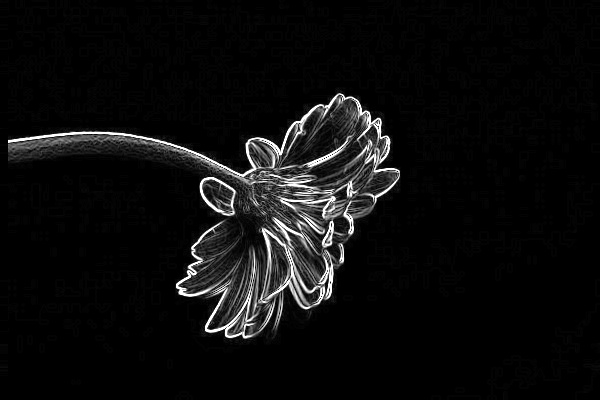

In [139]:
from PIL import Image
output_image = Image.open("/content/drive/MyDrive/ParallelProgramming/CA/output/output_cuda1_image.jpg")
display(output_image)

# Loop Unrolling - base 2

In [140]:
%%writefile cuda_version_lu2.cu

#include <cuda_runtime.h>
#include <device_launch_parameters.h>
#include <opencv2/opencv.hpp>
#include <iostream>
#include <vector>
#include "common.h"

using namespace cv;
using namespace std;

__global__ void sobel_kernel(const uchar* img, uchar* output, int rows, int cols, const int* kernel_x, const int* kernel_y) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    int index = y * cols + x;
    float sum_x = 0.0f, sum_y = 0.0f;

    int i, kx1, ky1, kx2, ky2, neighbor_index1, neighbor_index2;
    if (x > 0 && x < cols - 1 && y > 0 && y < rows - 1) {
        for (i = 0; i < 9; i += 2) {
            kx1 = i % 3 - 1;
            ky1 = i / 3 - 1;
            kx2 = (i + 1) % 3 - 1;
            ky2 = (i + 1) / 3 - 1;

            neighbor_index1 = (y + ky1) * cols + (x + kx1);
            neighbor_index2 = (y + ky2) * cols + (x + kx2);

            sum_x += img[neighbor_index1] * kernel_x[(ky1 + 1) * 3 + (kx1 + 1)];
            sum_y += img[neighbor_index1] * kernel_y[(ky1 + 1) * 3 + (kx1 + 1)];

            sum_x += img[neighbor_index2] * kernel_x[(ky2 + 1) * 3 + (kx2 + 1)];
            sum_y += img[neighbor_index2] * kernel_y[(ky2 + 1) * 3 + (kx2 + 1)];
        }
    }

    float magnitude = sqrtf(sum_x * sum_x + sum_y * sum_y);
    output[index] = (x > 0 && x < cols - 1 && y > 0 && y < rows - 1) ? static_cast<uchar>(min(magnitude, 255.0f)) : 0;
    __syncthreads();
}

void apply_cuda_filter(const Mat& img, Mat& output, const vector<vector<int>>& kernel_x, const vector<vector<int>>& kernel_y) {
    int rows = img.rows, cols = img.cols;
    uchar *d_img, *d_output;
    int *d_kernel_x, *d_kernel_y;
    size_t img_size = rows * cols * sizeof(uchar);
    size_t kernel_size = 3 * 3 * sizeof(int);

    CHECK(cudaMalloc(&d_img, img_size));
    CHECK(cudaMalloc(&d_output, img_size));
    CHECK(cudaMalloc(&d_kernel_x, kernel_size));
    CHECK(cudaMalloc(&d_kernel_y, kernel_size));
    int flat_kernel_x[9] = {
        kernel_x[0][0], kernel_x[0][1], kernel_x[0][2],
        kernel_x[1][0], kernel_x[1][1], kernel_x[1][2],
        kernel_x[2][0], kernel_x[2][1], kernel_x[2][2]
    };
    int flat_kernel_y[9] = {
        kernel_y[0][0], kernel_y[0][1], kernel_y[0][2],
        kernel_y[1][0], kernel_y[1][1], kernel_y[1][2],
        kernel_y[2][0], kernel_y[2][1], kernel_y[2][2]
    };

    CHECK(cudaMemcpy(d_img, img.data, img_size, cudaMemcpyHostToDevice));
    CHECK(cudaMemcpy(d_kernel_x, flat_kernel_x, kernel_size, cudaMemcpyHostToDevice));
    CHECK(cudaMemcpy(d_kernel_y, flat_kernel_y, kernel_size, cudaMemcpyHostToDevice));

    dim3 block_dim(16, 16);
    dim3 grid_dim((cols + block_dim.x - 1) / block_dim.x, (rows + block_dim.y - 1) / block_dim.y);

    double start = seconds();
    sobel_kernel<<<grid_dim, block_dim>>>(d_img, d_output, rows, cols, d_kernel_x, d_kernel_y);
    CHECK(cudaDeviceSynchronize());
    double end = seconds();

    cout << "CUDA Kernel Execution Time: " << (end - start) << " seconds" << endl;

    output.create(rows, cols, CV_8U);
    CHECK(cudaMemcpy(output.data, d_output, img_size, cudaMemcpyDeviceToHost));
    CHECK(cudaFree(d_img));
    CHECK(cudaFree(d_output));
    CHECK(cudaFree(d_kernel_x));
    CHECK(cudaFree(d_kernel_y));
}

int main() {
    string input_path = "/content/drive/MyDrive/ParallelProgramming/CA/input.jpg";
    string output_path = "/content/drive/MyDrive/ParallelProgramming/CA/output/output_cuda2_image.jpg";

    Mat input_image = imread(input_path, IMREAD_GRAYSCALE);
    if (input_image.empty()) {
        cerr << "Couldn't open the image file: " << input_path << endl;
        return -1;
    }
    vector<vector<int>> sobel_x = {
        {-1, 0, 1},
        {-2, 0, 2},
        {-1, 0, 1}
    };
    vector<vector<int>> sobel_y = {
        {1, 2, 1},
        {0, 0, 0},
        {-1, -2, -1}
    };

    Mat result;
    apply_cuda_filter(input_image, result, sobel_x, sobel_y);
    cout << "Output saved to: " << output_path << endl;
    return 0;
}


Overwriting cuda_version_lu2.cu


In [141]:
!nvcc cuda_version_lu2.cu -o lu2 `pkg-config --cflags --libs opencv4`

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [142]:
!./lu2

CUDA Kernel Execution Time: 0.000233889 seconds
Output saved to: /content/drive/MyDrive/ParallelProgramming/CA/output/output_cuda2_image.jpg


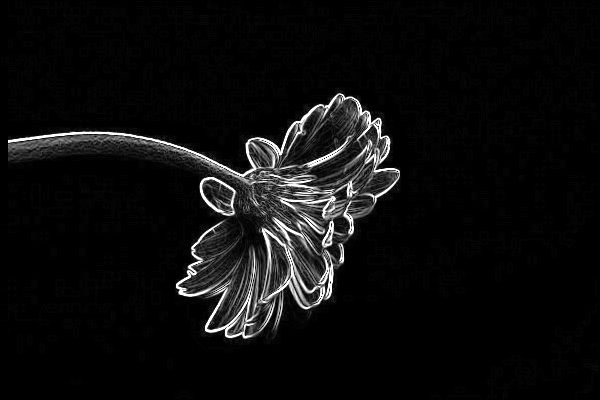

In [143]:
from PIL import Image
output_image = Image.open("/content/drive/MyDrive/ParallelProgramming/CA/output/output_cuda2_image.jpg")
display(output_image)

# Loop Unrolling - base 4

In [152]:
%%writefile cuda_version_lu4.cu

#include <cuda_runtime.h>
#include <device_launch_parameters.h>
#include <opencv2/opencv.hpp>
#include <iostream>
#include <vector>
#include "common.h"

using namespace cv;
using namespace std;

__global__ void sobel_kernel(const uchar* img, uchar* output, int rows, int cols, const int* kernel_x, const int* kernel_y) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    int index = y * cols + x;

    float sum_x = 0.0f, sum_y = 0.0f;
    int i, j, kx, ky, neighbor_index;

    if (x > 0 && x < cols - 1 && y > 0 && y < rows - 1) {
        for (i = 0; i < 9; i += 4) {
            for (j = 0; j < 4 && (i + j) < 9; ++j) {
                kx = (i + j) % 3 - 1;
                ky = (i + j) / 3 - 1;
                neighbor_index = (y + ky) * cols + (x + kx);
                sum_x += img[neighbor_index] * kernel_x[(ky + 1) * 3 + (kx + 1)];
                sum_y += img[neighbor_index] * kernel_y[(ky + 1) * 3 + (kx + 1)];
            }
        }
    }

    float magnitude = sqrtf(sum_x * sum_x + sum_y * sum_y);
    output[index] = (x > 0 && x < cols - 1 && y > 0 && y < rows - 1) ? static_cast<uchar>(min(magnitude, 255.0f)) : 0;
    __syncthreads();
}

void apply_cuda_filter(const Mat& img, Mat& output, const vector<vector<int>>& kernel_x, const vector<vector<int>>& kernel_y) {
    int rows = img.rows, cols = img.cols;
    uchar *d_img, *d_output;
    int *d_kernel_x, *d_kernel_y;
    size_t img_size = rows * cols * sizeof(uchar);
    size_t kernel_size = 3 * 3 * sizeof(int);

    CHECK(cudaMalloc(&d_img, img_size));
    CHECK(cudaMalloc(&d_output, img_size));
    CHECK(cudaMalloc(&d_kernel_x, kernel_size));
    CHECK(cudaMalloc(&d_kernel_y, kernel_size));

    int flat_kernel_x[9] = {
        kernel_x[0][0], kernel_x[0][1], kernel_x[0][2],
        kernel_x[1][0], kernel_x[1][1], kernel_x[1][2],
        kernel_x[2][0], kernel_x[2][1], kernel_x[2][2]
    };

    int flat_kernel_y[9] = {
        kernel_y[0][0], kernel_y[0][1], kernel_y[0][2],
        kernel_y[1][0], kernel_y[1][1], kernel_y[1][2],
        kernel_y[2][0], kernel_y[2][1], kernel_y[2][2]
    };

    CHECK(cudaMemcpy(d_img, img.data, img_size, cudaMemcpyHostToDevice));
    CHECK(cudaMemcpy(d_kernel_x, flat_kernel_x, kernel_size, cudaMemcpyHostToDevice));
    CHECK(cudaMemcpy(d_kernel_y, flat_kernel_y, kernel_size, cudaMemcpyHostToDevice));

    dim3 block_dim(16, 16);
    dim3 grid_dim((cols + block_dim.x - 1) / block_dim.x, (rows + block_dim.y - 1) / block_dim.y);

    double start = seconds();
    sobel_kernel<<<grid_dim, block_dim>>>(d_img, d_output, rows, cols, d_kernel_x, d_kernel_y);
    CHECK(cudaDeviceSynchronize());
    double end = seconds();

    cout << "CUDA Kernel Execution Time: " << (end - start) << " seconds" << endl;

    output.create(rows, cols, CV_8U);
    CHECK(cudaMemcpy(output.data, d_output, img_size, cudaMemcpyDeviceToHost));

    CHECK(cudaFree(d_img));
    CHECK(cudaFree(d_output));
    CHECK(cudaFree(d_kernel_x));
    CHECK(cudaFree(d_kernel_y));
}

int main() {
    string input_path = "/content/drive/MyDrive/ParallelProgramming/CA/input.jpg";
    string output_path = "/content/drive/MyDrive/ParallelProgramming/CA/output/output_cuda4_image.jpg";

    Mat input_image = imread(input_path, IMREAD_GRAYSCALE);
    if (input_image.empty()) {
        cerr << "Couldn't open the image file: " << input_path << endl;
        return -1;
    }

    vector<vector<int>> sobel_x = {
        {-1, 0, 1},
        {-2, 0, 2},
        {-1, 0, 1}
    };

    vector<vector<int>> sobel_y = {
        {1, 2, 1},
        {0, 0, 0},
        {-1, -2, -1}
    };

    Mat result;
    apply_cuda_filter(input_image, result, sobel_x, sobel_y);

    bool success = imwrite(output_path, result);
    if (!success) {
        cerr << "Failed to save the image to: " << output_path << endl;
        return -1;
    }

    cout << "Output saved to: " << output_path << endl;
    return 0;
}



Overwriting cuda_version_lu4.cu


In [153]:
!nvcc cuda_version_lu4.cu -o lu4 `pkg-config --cflags --libs opencv4`

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [154]:
!./lu4

CUDA Kernel Execution Time: 0.050035 seconds
Output saved to: /content/drive/MyDrive/ParallelProgramming/CA/output/output_cuda4_image.jpg


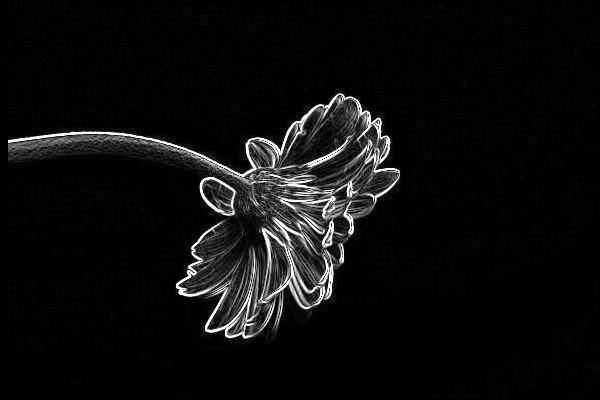

In [155]:
from PIL import Image
output_image = Image.open("/content/drive/MyDrive/ParallelProgramming/CA/output/output_cuda4_image.jpg")
display(output_image)

# Loop Unrolling -base 8

In [156]:
%%writefile cuda_version_lu8.cu

#include <cuda_runtime.h>
#include <device_launch_parameters.h>
#include <opencv2/opencv.hpp>
#include <iostream>
#include <vector>
#include "common.h"

using namespace cv;
using namespace std;

__global__ void sobel_kernel(const uchar* img, uchar* output, int rows, int cols, const int* kernel_x, const int* kernel_y) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    int index = y * cols + x;

    float sum_x = 0.0f, sum_y = 0.0f;
    int i, kx, ky, neighbor_x, neighbor_y, neighbor_index;

    if (x > 0 && x < cols - 1 && y > 0 && y < rows - 1) {
        for (i = 0; i < 8; ++i) {
            kx = i % 3 - 1;
            ky = i / 3 - 1;
            neighbor_x = x + kx;
            neighbor_y = y + ky;
            neighbor_index = neighbor_y * cols + neighbor_x;
            sum_x += img[neighbor_index] * kernel_x[(ky + 1) * 3 + (kx + 1)];
            sum_y += img[neighbor_index] * kernel_y[(ky + 1) * 3 + (kx + 1)];
        }

        neighbor_x = x + 1;
        neighbor_y = y + 1;
        neighbor_index = neighbor_y * cols + neighbor_x;
        sum_x += img[neighbor_index] * kernel_x[8];
        sum_y += img[neighbor_index] * kernel_y[8];
    }

    float magnitude = sqrtf(sum_x * sum_x + sum_y * sum_y);
    output[index] = (x > 0 && x < cols - 1 && y > 0 && y < rows - 1) ? static_cast<uchar>(min(magnitude, 255.0f)) : 0;
    __syncthreads();
}

void apply_cuda_filter(const Mat& img, Mat& output, const vector<vector<int>>& kernel_x, const vector<vector<int>>& kernel_y) {
    int rows = img.rows, cols = img.cols;
    uchar *d_img, *d_output;
    int *d_kernel_x, *d_kernel_y;
    size_t img_size = rows * cols * sizeof(uchar);
    size_t kernel_size = 3 * 3 * sizeof(int);

    CHECK(cudaMalloc(&d_img, img_size));
    CHECK(cudaMalloc(&d_output, img_size));
    CHECK(cudaMalloc(&d_kernel_x, kernel_size));
    CHECK(cudaMalloc(&d_kernel_y, kernel_size));

    int flat_kernel_x[9] = {
        kernel_x[0][0], kernel_x[0][1], kernel_x[0][2],
        kernel_x[1][0], kernel_x[1][1], kernel_x[1][2],
        kernel_x[2][0], kernel_x[2][1], kernel_x[2][2]
    };

    int flat_kernel_y[9] = {
        kernel_y[0][0], kernel_y[0][1], kernel_y[0][2],
        kernel_y[1][0], kernel_y[1][1], kernel_y[1][2],
        kernel_y[2][0], kernel_y[2][1], kernel_y[2][2]
    };

    CHECK(cudaMemcpy(d_img, img.data, img_size, cudaMemcpyHostToDevice));
    CHECK(cudaMemcpy(d_kernel_x, flat_kernel_x, kernel_size, cudaMemcpyHostToDevice));
    CHECK(cudaMemcpy(d_kernel_y, flat_kernel_y, kernel_size, cudaMemcpyHostToDevice));

    dim3 block_dim(16, 16);
    dim3 grid_dim((cols + block_dim.x - 1) / block_dim.x, (rows + block_dim.y - 1) / block_dim.y);

    double start = seconds();
    sobel_kernel<<<grid_dim, block_dim>>>(d_img, d_output, rows, cols, d_kernel_x, d_kernel_y);
    CHECK(cudaDeviceSynchronize());
    double end = seconds();

    cout << "CUDA Kernel Execution Time: " << (end - start) << " seconds" << endl;

    output.create(rows, cols, CV_8U);
    CHECK(cudaMemcpy(output.data, d_output, img_size, cudaMemcpyDeviceToHost));

    CHECK(cudaFree(d_img));
    CHECK(cudaFree(d_output));
    CHECK(cudaFree(d_kernel_x));
    CHECK(cudaFree(d_kernel_y));
}

int main() {
    string input_path = "/content/drive/MyDrive/ParallelProgramming/CA/input.jpg";
    string output_path = "/content/drive/MyDrive/ParallelProgramming/CA/output/output_cuda8_image.jpg";

    Mat input_image = imread(input_path, IMREAD_GRAYSCALE);
    if (input_image.empty()) {
        cerr << "Couldn't open the image file: " << input_path << endl;
        return -1;
    }

    vector<vector<int>> sobel_x = {
        {-1, 0, 1},
        {-2, 0, 2},
        {-1, 0, 1}
    };

    vector<vector<int>> sobel_y = {
        {1, 2, 1},
        {0, 0, 0},
        {-1, -2, -1}
    };

    Mat result;
    apply_cuda_filter(input_image, result, sobel_x, sobel_y);

    bool success = imwrite(output_path, result);
    if (!success) {
        cerr << "Failed to save the image to: " << output_path << endl;
        return -1;
    }

    cout << "Output saved to: " << output_path << endl;
    return 0;
}

Overwriting cuda_version_lu8.cu


In [157]:
!nvcc cuda_version_lu8.cu -o lu8 `pkg-config --cflags --libs opencv4`

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [158]:
!./lu8

CUDA Kernel Execution Time: 0.0479412 seconds
Output saved to: /content/drive/MyDrive/ParallelProgramming/CA/output/output_cuda8_image.jpg


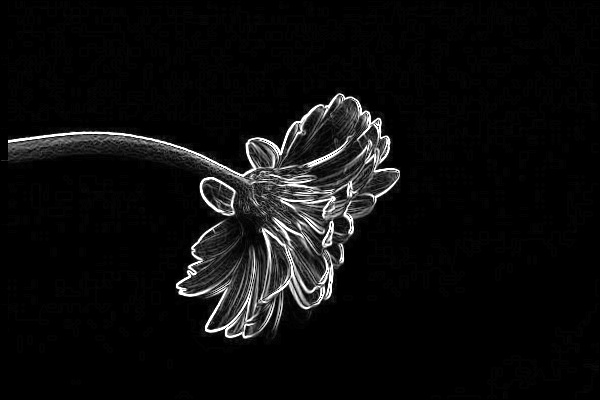

In [159]:
from PIL import Image
output_image = Image.open("/content/drive/MyDrive/ParallelProgramming/CA/output/output_cuda8_image.jpg")
display(output_image)